In [ ]:
import torch
import os
import math

# Add location of the data directory
FILENAME_PREFIX = ''
# Add filename prefix to be used for different epochs, e.g. PREFIX_1.pt, PREFIX_2.pt, etc.
FILENAME_PREFIX = "all_grads_epoch_"
# Add application of the experiments, e.g. SGD, CTT
APPLICATION = "SGD"
EPOCH = str(1)

In [2]:
def emax(x: torch.Tensor, shift: int = 100) -> float:
    """Calculate the epsilon value for the given tensor x, with shift for shift * epsilon."""
    n = x.shape[0]
    x_bar = torch.mean(x, dim=0)
    max_norm = 0
    import math

    for i in range(n):
        norm = torch.linalg.norm(x[i] - x_bar)
        if norm > max_norm:
            max_norm = norm
    print
    epsilon = shift * max_norm / math.sqrt(n)
    return epsilon

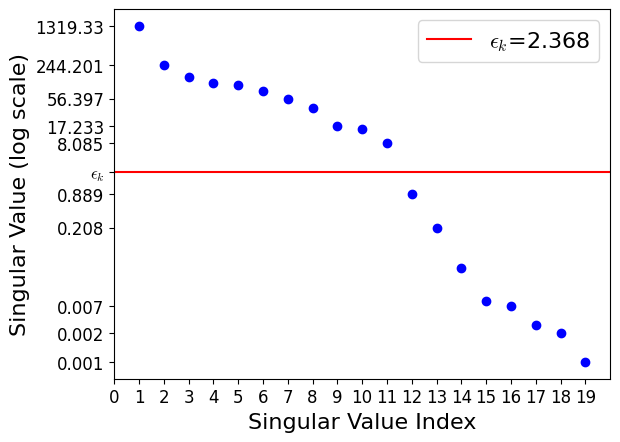

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({"font.size": 16})
fname = FILENAME_PREFIX + EPOCH + ".pt"
grads = torch.load(fname, map_location=torch.device("cpu"))
grads = grads.squeeze(0)

svs = torch.linalg.svdvals(grads)

svs_greater = 0

# shift = sqrt(9*e*ln(48821400) ln(48821400 * (1 + ln(244107/2))))
shift = math.sqrt(9 * math.e * math.log(48821400) * math.log(48821400 * (1 + math.log(244107 / 2))))

epsilon = emax(grads, shift=shift).item()

for i, sv in enumerate(svs):
    plt.scatter((i + 1), math.log(sv), color="b")
    if sv > epsilon:
        svs_greater += 1
# round epsilon to 3 decimal places
epsilon = round(epsilon, ndigits=3)
plt.xlim(0, len(svs) + 1)
plt.xticks(range(0, len(svs) + 1), fontsize=12)
# increase y axis to include epsilon


def isvalid(i: float, idx: int) -> bool:
    """Get valid indicesf for plot, specific to this plot"""
    if i > 57 and i < 244:
        return False
    if i > 8 and i < 244:
        if idx == 4:
            return False
        return idx % 2 == 0
    if idx == 13 or idx == 14 or idx == 16:
        return False
    return True


yticks = [math.log(i) for idx, i in enumerate(svs) if isvalid(i, idx)]
yticks.append(math.log(epsilon))

yticklabels = [
    round(i.item(), ndigits=3) for idx, i in enumerate(svs) if isvalid(i, idx)
]
yticklabels.append("$\epsilon_k$")
plt.yticks(yticks, labels=yticklabels, fontsize=12)
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value (log scale)")

# plot horizontal line at epsilon
plt.axhline(
    y=math.log(epsilon), color="r", linestyle="-", label=f"$\epsilon_k$={epsilon}"
)
plt.legend()
plt.savefig(f"svs_scatter_{APPLICATION}.pdf", bbox_inches="tight")
plt.savefig(f"svs_scatter_{APPLICATION}.png")

In [4]:
all_grads = []
for i in range(1, 51):
    all_grads.append(FILENAME_PREFIX + str(i) + ".pt")
print(f"{len(all_grads)} files found")

svs_greater = []

for filename in all_grads:
    # check if filename exists
    if not os.path.exists(filename):
        continue
    grads = torch.load(filename, map_location=torch.device("cpu")).squeeze(0)
    e = emax(grads, shift=shift).item()
    sv_greater = 0
    svs = torch.linalg.svdvals(grads)
    for sv in svs:
        if sv > e:
            sv_greater += 1
    svs_greater.append(sv_greater)

50 files found


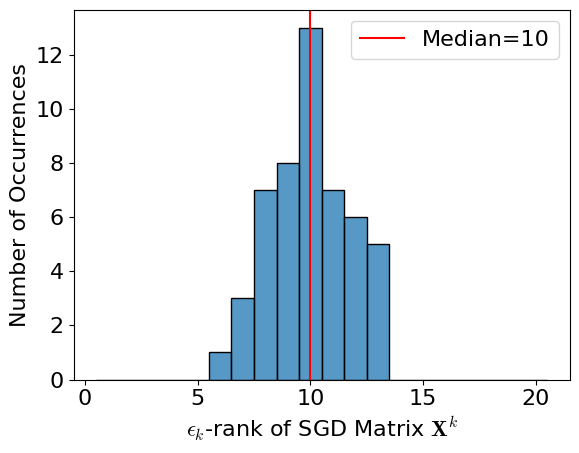

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
bin_edges = np.arange(0.5, 20.6, 1)
# fig = sns.histplot(svs_greater, bins=range(0, 21))
fig = sns.histplot(svs_greater, bins=bin_edges)
fig.set(
    xlabel="$\epsilon_k$-rank of SGD Matrix $\mathbf{X}^k$",
    ylabel="Number of Occurrences",
)
# Add median line
svs_greater.sort()
median_idx = len(svs_greater) // 2
median = svs_greater[median_idx]

plt.axvline(x=median, color="r", linestyle="-", label=f"Median={median}")
plt.legend()
plt.savefig(f"svs_hist_{APPLICATION}.pdf", bbox_inches="tight")